# Scientific Paper Analysis

This notebook performs several actions to analyse (a) a 'seed' scientific paper, and (b) extract and download any references that can be found in that paper in arXiv.org. It can perform that step recursively, to build up a small graph of papers referred to by other papers. 

It uses a lot of heuristics and regular expressions to parse PDF files. Due to the huge variety of citation formats, it is very brittle. 



## Import dependencies, other preparation tasks

(Note: dependies should be first installed via requirements.txt).

In [1]:

# Common Python libraries, used for regular expressions, file downloads and other things
import os, os.path
import re
import urllib, urllib.request, urllib.parse
# Parse arXiv API responses (in ATOM XML format)
import xml.etree.ElementTree as ET

# Alternative to print()
from icecream import ic

# Used to extract PDF text
import textract

# Numpy and Pandas for data manipulation.
# All references stored in a Pandas DataFrame for easy analysis.
import numpy as np
import pandas as pd

# Not used yet - but helpful for simple machine learning tasks.
# Maybe helpful for text summarisation in particular.
from transformers import pipeline

# Natural Language Toolkit - for tokenisation and basic linguistic analysis
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn

# Simple word cloud generator
from wordcloud import WordCloud

# Google Scholar wrapper - not that useful yet
from scholarly import scholarly


The code below downloads a set of English language stopwords ('a', 'the' etc), and adds commonly occuring terms in PDFs, to remove further noise.

In [2]:
# Preparatory steps
nltk.download('stopwords')
full_stop_words = set(nltk.corpus.stopwords.words('english'))

full_stop_words.add('b')
full_stop_words.add('c')
full_stop_words.add('d')
full_stop_words.add('e')
full_stop_words.add('f')
full_stop_words.add('g')
full_stop_words.add('h')
full_stop_words.add('j')
full_stop_words.add('k')
full_stop_words.add('l')
full_stop_words.add('m')
full_stop_words.add('n')
full_stop_words.add('p')
full_stop_words.add('q')
full_stop_words.add('r')
full_stop_words.add('u')
full_stop_words.add('v')
full_stop_words.add('x')
full_stop_words.add('w')
full_stop_words.add('y')
full_stop_words.add('z')
full_stop_words.add('pp')
full_stop_words.add('et')
full_stop_words.add('al')
full_stop_words.add('ha')
full_stop_words.add('li')
full_stop_words.add('sij')
full_stop_words.add('arxiv')

[nltk_data] Downloading package stopwords to /Users/liam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reference Extraction and Parsing


A series of regular expression utilities for parsing and extraction whoe references from PDFs.



In [3]:
# Common functions for parsing references from plain text

def re_matches(text, regex):
    iterator = re.findall(regex, text)

    refs = []
    for match in iterator:
        refs.append(match) 

    return refs

def re_digit():
    return r'\[\d*\]\ '

def re_first_first():
    return r'(?:(?:\-?[A-Z]\.\ )+(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\,?\ ?)+)'

def re_first_first_multiple():
    return r'(?:' + re_first_first() +'+and\ )?'

def re_first_last():
    return r'(?:(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+)+\,\ (?:\-?[A-Z]\.\ ?)+)'

def re_first_last_multiple():
    return '(?:(?:' + re_first_last() +'\,\ )+' + re_first_last() + r'\,?\ and\ )?'

def re_full_first():
    return r'(?:(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\ )+(?:\-?[A-Z]\.?\ )*(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\,?\ ?)+)'

def re_year():
    return r'\(?(?:\d{4})\)?'

def re_trailing_digit():
    return r'(?:[\d\ \,]+\ )?'


def re_in_journal():
    return r'(?:(?:in)?\ [^\,]+\,\ )'

def re_pages():
    return r'(?:\ (?:pp\.\ )?\d+\-?\d+)?'


# Type 0
# Example: 2106.12139.pdf
def gen_refs_with_pages(text):
    r = ( 
        re_digit() 
        + r'('
        + re_first_first()  
        + r'[^\[\u201c-\u201f]*?\,?\ ' 
        + re_year() 
        + re_pages()
        + r')'
        + r'\.?'
        # + re_trailing_digit() 
        )
    regex = re.compile(r)
    return re_matches(text, regex)

# Type 1
# Example: Fashionista: A fashion-aware graphical system for exploring
def gen_refs_end_year_firstname_first(text):
    r = ( 
        re_digit() 
        + r'('
        # + re_first_first_multiple() 
        + re_first_first()  
        + r'[^\[\,]*?' 
        + re_in_journal()
        + r'[^\[]*?' 
        + re_year() 
        + r'\.'
        + r')'
        )
    regex = re.compile(r)    
    return re_matches(text, regex) 

# Type 2
# Example: Fashion-gen: The generative fashion dataset and challenge.pdf
def gen_refs_end_year_firstname_last(text):
    regex = r'((?:(?:[A-Zvd][A-Za-zá\-\ ]+\,\ (?:\-?[A-Z]\.\ ?)+(?:\,\ )?)*)(?:\,?\ and\ )?(?:[A-Zvd][A-Za-zá\-\ ]+\,\ (?:\-?[A-Z]\.\ ?)+)[^\.]*\.\ [^\.]*\,\ \d{4}\.)'
    r = ( 
        r'('
        + re_first_last_multiple() 
        + re_first_last()  
        # + r'[^\[]*?\,?\ ' 
        + r'[^\[]*?\,?\ ' 
        # + re_pages()
        + re_year() 
        + r'\.'
        + r')'
        )
    regex = re.compile(r)    
    return re_matches(text, regex) 


# Type 3
# Example: A compact embedding for facial expression similarity.pdf
def gen_refs_with_pages_conjoined(text):
    r = ( 
        # re_digit() 
        r'('
        + re_first_first_multiple() 
        + re_first_first()  
        + r'\.[^\[]*?\,\ ' 
        + re_year() 
        + r'\.' 
        + re_trailing_digit() 
        + r')'
        )
    regex = re.compile(r)
    return re_matches(text, regex)

# Type 4
# Example: Shapenet/ An information-rich 3d model repository.pdf
def gen_refs_expanded_name(text):
    r = ( 
        r'\[(?:\d+)\]\ '
        + r'('
        + re_full_first()  
        + r'[^\[]*?\,?\ ' 
        + re_year() 
        + r'\.?'
        + r')'
        )
    regex = re.compile(r)    
    return re_matches(text, regex) 


# Main reference 'generator'. Looks for a variety of reference patterns,
# and returns, along with the extracted references, a number that acts to flag
# the best internal reference parsing option to apply.
def gen_refs_multiple_pass(text):
    refs0 = gen_refs_with_pages(text)
    refs1 = gen_refs_end_year_firstname_first(text)
    refs2 = gen_refs_end_year_firstname_last(text)
    refs3 = gen_refs_with_pages_conjoined(text)

    # Don't use this just yet - too greedy
    refs4 = gen_refs_expanded_name(text)

    lst = [refs0, refs1, refs2, refs3, refs4]
    lst_sorted = sorted(lst, key=len, reverse=True)
    refs = lst_sorted[0]
    ref_type = lst.index(refs)

    # Specific checks
    if ref_type == 0 and len(refs0) == len(refs1):
        refs = refs1
        ref_type = 1

    return refs, ref_type




Again, messy code to parse a reference string into parts (authors, title, journal / conference, publisher, volume, pages, year).

The type returned by gen_refs_multiple_pass() corresponds to the parse_refX function invoked here.

In [4]:
# Common functions for extracting references parts

# Makes a data frame object from a set of reference parameters
def make_dataframe(authors, title, journal, publisher, volume, year, pages, ref, source_file, source_title):
    return pd.DataFrame([[(', ').join(authors), title, journal, publisher, volume, year, pages, ref, source_file, source_title]], 
                        columns = ['authors', 'title', 'journal', 'publisher', 'volume', 'year', 'pages', 'full_ref', 'source_file', 'source_title'])

# Uses a general citation pattern to extract the authors, title, journal, volume, year, and pages
# The author pattern extracts individual authors. 
# The mapping object enables different orders in the regular expression.
def _parse_ref_internals(ref, citation_pattern, authors_pattern, mapping = {
        'first_authors': 0,
        'last_author': 1,
        'title': 2,
        'journal': 3,
        'publisher': 4,
        'volume': 5,
        'year': 6,
        'pages': 7
    }):
    all_authors = []
    title = ''
    journal = ''
    publisher = ''
    volume = ''
    year = ''
    pages = ''

    iterator = re.findall(citation_pattern, ref)
    for i in iterator:
        first_authors = i[mapping['first_authors']]
        last_author = i[mapping['last_author']].strip()
        title = i[mapping['title']]
        # Important to try to get the title right
        if title.find('.') >= 0:
            title_trap = re.compile(r'(?:[^\.]{,10}\.)*([^\.]+)\.')
            i2 = re.findall(title_trap, title)
            title = i2[0]
        journal = i[mapping['journal']]
        publisher = i[mapping['publisher']]
        volume = i[mapping['volume']]
        year = i[mapping['year']]
        pages = i[mapping['pages']]
        if first_authors != '':
            authors = re.findall(authors_pattern, first_authors)
            for a in authors:
                all_authors.append(a)
        all_authors.append(last_author)
    return all_authors, title, journal, publisher, volume, year, pages

# Parses a reference that follows this pattern:
# Y. Guo, Y. Liu, A. Oerlemans, S. Lao, S. Wu, M.S. Lew, Deep learning for visual understanding: A review, Neurocomputing, 187 (2016) 27-48
# From 2106.12139.pdf
# - Year before pages
# - All fields are comma-separated
# - Authors are not joined by a conjuntion
def parse_ref0(ref):
    citation_pattern = re.compile(
        r'((?:(?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+)\,\ )*)' # authors
        + r'((?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+))\,\ ' # last author
        + r'([^\,\.]*)\,\ ' # title
        + r'((?:[^\,]*)\,\ )?' # journal
        + r'((?:[^\,]*)\,\ )?' # publisher
        + r'(\d+\ )?' # volume
        + r'\(?(\d{4})\)?\,?\ ?' # year
        + r'(?:pp\.\ )?(\d+\-\d+)?'  # pages
        )
    authors_pattern = re.compile(
        r'((?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\ \-]+))')

    return _parse_ref_internals(ref, citation_pattern, authors_pattern)


# Parses a reference that follows this pattern:
def parse_ref1(ref):
    citation_pattern = re.compile(
        r'((?:(?:\-?[A-Z]\.\ ?)+(?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+)\,?\ )*and\ )?' 
        + r'((?:\-?[A-Zvd]\.\ ?)+(?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+))[\,\.]\ '  # last author
        + r'[\u0080-\uFFFF]?([^\,\.]*)[\,\.\u0080-\uFFFF]+' # title
        + r'(?:\ in\ )?([^\,\.]*)?' # journal
        + r'(?:\:?([^\,]*)\,\ )?' # publisher 
        + r'(?:vol\. (\d+)\ )?' # volume
        + r'(?:(?:pp\.\ )?(\d+\-?\d+)(?:\,?\ ?))?' # pages
        # + r'()'
        # + r'()'
        # + r'()'
        + r'.*(\d{4})\.' # years
        # + r'(\!)?'
        ) 
    authors_pattern = re.compile(r'(?:\-?[A-Z]\.\ ?)+[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+')

    return _parse_ref_internals(ref, citation_pattern, authors_pattern, mapping = {
        'first_authors': 0,
        'last_author': 1,
        'title': 2,
        'journal': 3,
        'publisher': 4,
        'volume': 5,
        'pages': 6,
        'year': 7
    })

# Parses a reference that follows this pattern:
def parse_ref2(ref):
    
    citation_pattern = re.compile(
        r'((?:(?:[A-Zvd][A-Za-z\-\ \u0080-\uFFFF]+)+\,\ (?:\-?[A-Z]\.\ ?)+(?:\,\ )?)*)(?:\,?\ and\ )?'
        + r'([A-Zvd][A-Za-za\-\ \u0080-\uFFFF]+\,\ (?:\-?[A-Z]\.\ ?)+)' 
        + r'([^\.]*)' # title
        + r'\.\ '
        + r'((?:[^\,]*))?'  # journal
        + r'(?:\,\ (.*(?:pp\.\ |d+\(d+\)\:)?\d+(?:\-\d*)?))?' # pages 
        + r'(\.\ (?:[^\,]*))?' # publisher
        + r'\,\ '
        + r'(\d{4})'
        + r'(\,\ \d+\ )?' # volume
        # + r'\.'
        )
    authors_pattern = re.compile(
        r'(?:[A-Zvd][A-Za-za\-\u0080-\uFFFF]+)+\,\ (?:\-?[A-Z]\.\ ?)+')

    return _parse_ref_internals(ref, citation_pattern, authors_pattern, mapping = {
        'first_authors': 0,
        'last_author': 1,
        'title': 2,
        'journal': 3,
        'pages': 4,
        'publisher': 5,
        'volume': 7,
        'year': 6
    })

def parse_ref3(ref):
    citation_pattern = re.compile(
        r'((?:(?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\ \-]+\,\ ))*)and\ ((?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\ \-]+\.))?' 
        + r'([^\,]*)\,\ ([^\,]*)\,\ (?:([^\,]*)\,\ )?' 
        + r'(?:(\d+)\ )?' # volume
        + r'\(?(\d{4})\)?\,?\ ?' 
        + r'(?:pp\.\ )?(\d+\-?\d+)?')
    authors_pattern = re.compile(r'((?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\ \-]+))')

    return _parse_ref_internals(ref, citation_pattern, authors_pattern)


def parse_ref4(ref):
    citation_pattern = re.compile(
        r'((?:(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\ )+(?:\-?[A-Z]\.?\ )*(?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+)\,?\ )*)and\ ' 
        + r'((?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\ )+(?:\-?[A-Zvd]\.?\ )*(?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+))[\,\.]\ (?:et\ al\.\ )?'  # last author
        + r'([^\.]*)\.\ ' # title
        + r'(?:In\ )?([^\,]*)(?:[\,\.]\ )' # journal
        + r'(\d+(?:\(\d+\))?\:?)?' # volume
        + r'(?:pages\ )?(\d+(?:[\–|\u2014]\d+)?)?' # pages
        + r'(?:([^\,]*)\,\ )?' # publisher 
        # + r'(\!)?'
        # + r'(\!)?'
        # + r'(\!)?'
        + r'.*(\d{4})?\.' # year
        # + r'(\!)?'
        ) 
    authors_pattern = re.compile(r'(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\ )+(?:\-?[A-Z]\.\ )*[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+')

    return _parse_ref_internals(ref, citation_pattern, authors_pattern, mapping = {
        'first_authors': 0,
        'last_author': 1,
        'title': 2,
        'journal': 3,
        'volume': 4,
        'pages': 5,
        'publisher': 6,
        'year': 7
    })

def parse_ref(ref, ref_type):
    if ref_type == 0:
        return parse_ref0(ref)
    elif ref_type == 1:
        return parse_ref1(ref)
    elif ref_type == 2:
        return parse_ref2(ref)
    elif ref_type == 3:
        return parse_ref3(ref)
    elif ref_type == 4:
        return parse_ref4(ref)
    else:
        return parse_ref0(ref)


def parse_ref_and_makedataframe(ref, ref_type, source_file, source_title):
    authors, title, journal, publisher, volume, year, pages = parse_ref(ref, ref_type)
    return make_dataframe(authors, title, journal, publisher, volume, year, pages, ref, source_file, source_title)




A set of utility functions to help with processing PDF and analysing text.

In [5]:
# Other utility functions

def get_lemma(word):
    return WordNetLemmatizer().lemmatize(word)

def remove_set_from_dict(s, d):
    for t in s:
        if t in d:
            del d[t]
    return d
    
def word_frequencies(text):
    words = re.findall('[A-Za-z][A-Za-z0-9]*', text)
    frequencies = {}
    for w in words:
        w = w.lower()
        w = get_lemma(w)
        if w not in full_stop_words:
            if w in frequencies:
                frequencies[w] += 1
            else:
                frequencies[w] = 1
    return frequencies

def word_frequencies_dist(text, frequencies):
    words = re.findall('[A-Za-z][A-Za-z0-9]*', text)
    for w in words:
        w = w.lower()
        w = get_lemma(w)
        if w not in full_stop_words:
            if w in frequencies:
                frequencies[w] += 1
            else:
                frequencies[w] = 1
    return frequencies


def wc(freqs, file_name):
    wordcloud = WordCloud(background_color="white", width=600, height=600, max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    #wordcloud.generate(long_string)
    wordcloud.generate_from_frequencies(freqs)
    wordcloud.to_file(f'data/word-cloud-{file_name}.png')
    wordcloud.to_image()


def arxiv_results(title):
    t =  urllib.parse.quote_plus(title)
    url = 'http://export.arxiv.org/api/query?search_query=all:'+t+'&start=0&max_results=1'
    data = urllib.request.urlopen(url)
    return data.read().decode('utf-8')


def make_up_file_name(file_name, directory):
    return os.path.join(directory, file_name + '.pdf')


def extract_and_save_pdf_from_atom(atom_xml, title, title_no_colon, title_stem, directory, pass_through=False):
    root = ET.fromstring(atom_xml)
    for e in root.findall('{http://www.w3.org/2005/Atom}entry'):
        t = e.find('{http://www.w3.org/2005/Atom}title')
        link = e.find('{http://www.w3.org/2005/Atom}link')
        if t.text.lower().find(title_stem.lower()) == 0:
            for link in e.findall('{http://www.w3.org/2005/Atom}link'):
                # Title must match and link must be a pdf
                if 'type' in link.attrib and link.attrib['type'] == 'application/pdf':
                    u  = link.attrib['href']
                    # ic(u, title, directory)
                    if not pass_through:
                        urllib.request.urlretrieve(u, 
                            make_up_file_name(title, directory))


def test_element(atom_xml):
    try:
        root = ET.fromstring(atom_xml)
        entry = root.find('{http://www.w3.org/2005/Atom}entry')
        if entry is not None:
            return True
        else:
            return False
    except ET.ParseError as e:
        ic(e)


# Attempt to locate references on Arxiv, and save any found files as pdfs
def download_from_arxiv(titles, directory):
    counter = 0
    for title in titles:

        # Check if the string is empty
        if len(title) == 0:
            continue

        f = make_up_file_name(title, directory)
        
        counter = counter + 1

        # If the file already exists, 
        if not os.path.isfile(f):
            
            # Search for the title on Arxiv
            r = arxiv_results(title)

            # Create abridged versions
            title_stem = title
            title_no_colon = title
            if title.find(':') > -1:
                title_stem = title[:title.index(':')]
                title_no_colon = title[:title.index(':')] + title[title.index(':')+1:]
            
            # Did we find a result?
            has_entry = test_element(r)

            # Remove the semi-colon - seems to confuse Arxiv API
            if not has_entry:
                r = arxiv_results(title_no_colon)
                has_entry = test_element(r)

            # Remove everything after the semi-colon
            if not has_entry:
                r = arxiv_results(title_stem)
                has_entry = test_element(r)

            ic(counter, title)
            if has_entry:
                extract_and_save_pdf_from_atom(r, title, title_no_colon, title_stem, directory, False)


def top_dist(freqs, n):
    counter = 0
    for w in sorted(freqs, key = freqs.get, reverse = True):
        counter = counter + 1
        print(w, freqs[w])
        if counter == n:
            break

In [14]:


# Extract word frequencies and references from the pdfs.
def extract_frequences_and_references(d, freqs, references):

    all_freqs = {**freqs}
    all_references = references.copy()
    for file in os.listdir(d):

        # if file.endswith("Predictive and generative neural networks for object functionality.pdf"):
        if file.endswith(".pdf") and file.find('Deepfashion') == -1 and file.find('Predictive and generative') == -1:
            f = os.path.join(d, file)
            ic(f)
            try:
                text_local = textract.process(f).decode('utf-8')
                text_local = text_local.replace('\n', ' ')
                all_freqs = word_frequencies_dist(text_local, all_freqs)
                refs_local, ref_type  = gen_refs_multiple_pass(text_local)

                ic(ref_type, len(refs_local))
                counter = 0
                for r in refs_local:
                    counter = counter + 1

                    # if counter > 3:
                    #     break
                    # ic(r)

                    # authors, title, journal, publisher, volume, year, pages = parse_ref1(r)
                    # ic(authors)
                    # ic(title)
                    # ic(journal)
                    # ic(publisher)
                    # ic(volume)
                    # ic(pages)
                    # ic(year)

                    all_references = all_references.append(parse_ref_and_makedataframe(r, ref_type, f, ''))

            except Exception as e:
                # ic(e)
                pass
        
    return all_freqs, all_references


## Processing files

The code below analyses frequencies and extracts references for a 'seed' paper.

Both file name and title must be supplied, and the PDF file downloaded to the 'refs' directory first.

In [7]:

# # Input
file_name = '2106.12139.pdf'
title = 'PatentNet: A Large-Scale Incomplete Multiview, Multimodal, Multilabel Industrial Goods Image Database'

# Extract the text
text = textract.process("refs/" + file_name).decode('utf-8').replace('\n', ' ')

# Obtain word frequencies
freqs = word_frequencies(text)

# Set up a references dataframe
references = pd.DataFrame(columns = ['authors', 'title', 'journal', 'publisher', 'volume', 'year', 'pages', 'full_ref', 'source_file', 'source_title'])

# Extract the references
refs, ref_type = gen_refs_multiple_pass(text)

# Add the references to the dataframe
for r in refs:
    references = references.append(parse_ref_and_makedataframe(r, ref_type, file_name, title))

# Save references to a csv
references.to_csv('data/references.csv')



In [8]:
# Test code

# ic(references['title'])

# t = references['title'].iloc[7]
# print(t)
# r = arxiv_results(t.strip())
# print(r)
# # ET.tostring(r)

In [8]:
## Test code
def parse_ref_test(ref):
    citation_pattern = re.compile(
        r'((?:(?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+)\,\ )*)' # authors
        + r'((?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+))\,\ ' # last author
        + r'([^\,\.]*)\,\ ' # title
        + r'((?:[^\,]*)\,\ )?' # journal
        + r'((?:[^\,]*)\,\ )?' # publisher
        + r'(\d+\ )?' # volume
        + r'\(?(\d{4})\)?\,?\ ?' # year
        + r'(?:pp\.\ )?(\d+\-\d+)?'  # pages
        ) 
    authors_pattern = re.compile(r'(?:\-?[A-Z]\.\ )+[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+')
    iterator = re.findall(citation_pattern, ref)
    for i in iterator:
        ic(i)
        # first_authors = i[0]
        # last_author = i[1].strip()
        # title = i[2]
        # ic(first_authors)
        # ic(last_author)
        # ic(title)


# s = """Liu, Z., Luo, P., Wang, X., and Tang, X. Deep learning
# face attributes in the wild. In Proceedings of the IEEE
# International Conference on Computer Vision, pp. 3730–
s = """J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li, and L. Fei-Fei, “ImageNet: A Large-Scale Hierarchical Image Database,” in CVPR09, 2009."""
# 3738, 2015."""

# parse_ref_test(s)
# all_authors, title, journal, publisher, volume, year, pages = parse_ref0(s)
# ic(title)
# ic(pages)

# # \1{5}.*\d\d\d\d\.
# # regex = r'[A-Z][A-Za-z\,\.\ ]+[A-Z]\.\ [A-Z](?:.*\n.*){0,5}\,\ \d\d\d\d\.'
# regex = r'[A-Z][A-Za-z\-]+\,\ [A-Z]\.(?:.*\n.*){0,5}\,\ \d\d\d\d\.'
# pattern = re.compile(regex)
# iterator = re.findall(pattern, s)
# print(iterator)


In [9]:


# More test code.
# This is used to process and extract references from downloaded pdfs.
# It helps to check how the parsing code is identifying types of citations, 
# before actual parsing occurs.
def test_ref_type(file):
    f = os.path.join(file)
    text = textract.process(f).decode('utf-8')
    text = text.replace('\n', ' ')
    # regex = r'(?:[A-Zvd][A-Za-zá\-]+)\,\ (?:[A-Z]\.\ ?)+'
    # regex = r'((?:(?:[A-Zvd][A-Za-zá\-\ ]+\,\ (?:\-?[A-Z]\.\ ?)+(?:\,\ )?)*)(?:\,?\ and\ )?(?:[A-Zvd][A-Za-zá\-\ ]+\,\ (?:\-?[A-Z]\.\ ?)+)[^\.]*\.\ [^\.]*\,\ \d{4}\.)'
    # pattern = re.compile(regex)
    # iterator = re.findall(pattern, text)
    # ic(file)
    # for i in iterator:
    #     ic(i)
    refs_local, ref_type = gen_refs_multiple_pass(text)
    # refs_local = gen_refs_with_pages(text)
    # refs_local = gen_refs_end_year_firstname_first(text)
    # refs_local = gen_refs_end_year_firstname_last(text)
    # refs_local = gen_refs_with_pages_conjoined(text)
    # refs_local = gen_refs_expanded_name(text)
    
    # refs_local = gen_refs_text_brackets(text)
    # ref_type = 1
    ic(file)
    ic(ref_type)
    ic(len(refs_local))
    # ic(refs_local)
    # ic(text)



# test_ref_type('./refs/2106.12139.pdf')
# test_ref_type('./refs/download/A compact embedding for facial expression similarity.pdf')
# test_ref_type('./refs/download/Central similarity quantization for efficient image and video retrieval.pdf')
# test_ref_type('./refs/download/Doubly Aligned Incomplete Multi-view Clustering.pdf')
# test_ref_type('./refs/download/Efficientnet: Rethinking model scaling for convolutional neural networks.pdf')
# test_ref_type('./refs/download/Fashion-gen: The generative fashion dataset and challenge.pdf')
# test_ref_type('./refs/download/Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms.pdf')
# test_ref_type('./refs/download/Fashionista: A fashion-aware graphical system for exploring visually similar items.pdf')
# test_ref_type('./refs/download/Hashnet: Deep learning to hash by continuation.pdf')
# test_ref_type('./refs/download/Imagenet: A large-scale hierarchical image database.pdf')
test_ref_type('./refs/download/Partnet: A large-scale benchmark for finegrained and hierarchical part-level 3d object understanding.pdf')
# test_ref_type('./refs/download/Shapenet: An information-rich 3d model repository.pdf')





ic| file: ('./refs/download/Partnet: A large-scale benchmark for finegrained and '
           'hierarchical part-level 3d object understanding.pdf')
ic| ref_type: 1
ic| len(refs_local): 43


In [153]:

# Downloads files from references, where they can be found.
download_from_arxiv(references['title'], './refs/download')

ic| counter: 1
    title: 'Deep learning for visual understanding: A review'
ic| counter: 2
    title: ('Deep convolutional neural networks for image classification: A comprehensive '
            'review')
ic| counter: 5
    title: '3d shapenets: A deep representation for volumetric shapes'
ic| counter: 6
    title: ('Seeing 3d chairs: exemplar part-based 2d-3d alignment using a large dataset '
            'of cad models')
ic| counter: 7
    title: 'Benchmark Datasets for Fault Detection and Classification in Sensor Data'
ic| counter: 8
    title: 'A style-based generator architecture for generative adversarial networks'
ic| counter: 11
    title: '3d object representations for fine-grained categorization'
ic| counter: 13
    title: 'Fashionai: A hierarchical dataset for fashion understanding'
ic| counter: 16
    title: 'Very deep convolutional networks for large-scale image recognition'
ic| counter: 17, title: 'Going deeper with convolutions'
ic| counter: 18, title: 'Deep residual lea

In [21]:

d = './refs/download'
all_freqs, all_references = extract_frequences_and_references(d, freqs, references)
all_references.to_csv('data/all_references.csv')


ic| f: ('./refs/download/Fashionista: A fashion-aware graphical system for exploring '
        'visually similar items.pdf')
ic| ref_type: 1, len(refs_local): 7
ic| f: './refs/download/Fashion-gen: The generative fashion dataset and challenge.pdf'
ic| ref_type: 2, len(refs_local): 31
ic| f: ('./refs/download/Central similarity quantization for efficient image and '
        'video retrieval.pdf')
ic| ref_type: 3, len(refs_local): 44
ic| f: './refs/download/Doubly Aligned Incomplete Multi-view Clustering.pdf'
ic| ref_type: 1, len(refs_local): 0
ic| f: ('./refs/download/Partnet: A large-scale benchmark for finegrained and '
        'hierarchical part-level 3d object understanding.pdf')
ic| ref_type: 1, len(refs_local): 43
ic| f: ('./refs/download/Efficientnet: Rethinking model scaling for convolutional '
        'neural networks.pdf')
ic| ref_type: 2, len(refs_local): 52
ic| f: './refs/download/A compact embedding for facial expression similarity.pdf'
ic| ref_type: 3, len(refs_local): 52


In [184]:
all_titles = all_references['title']


# Test code - check whether titles have any periods still.
# counter = 0
# for t in all_titles:
#     counter = counter + 1
#     ic(t)
#     if t.find('.') >= 0:
#         if counter < 1000:
#             e = re.compile(r'(?:[^\.]{,10}\.)*([^\.]+)\.')
#             iterator = re.findall(e, t)
#             ic(counter, t, iterator[0])
    
download_from_arxiv(all_titles, './refs/download/2')

ic| counter: 1
    title: 'Deep learning for visual understanding: A review'
ic| counter: 2
    title: ('Deep convolutional neural networks for image classification: A comprehensive '
            'review')
ic| counter: 5
    title: '3d shapenets: A deep representation for volumetric shapes'
ic| counter: 6
    title: ('Seeing 3d chairs: exemplar part-based 2d-3d alignment using a large dataset '
            'of cad models')
ic| counter: 7
    title: 'Benchmark Datasets for Fault Detection and Classification in Sensor Data'
ic| counter: 8
    title: 'A style-based generator architecture for generative adversarial networks'
ic| counter: 11
    title: '3d object representations for fine-grained categorization'
ic| counter: 13
    title: 'Fashionai: A hierarchical dataset for fashion understanding'
ic| counter: 16
    title: 'Very deep convolutional networks for large-scale image recognition'
ic| counter: 17, title: 'Going deeper with convolutions'
ic| counter: 18, title: 'Deep residual lea

In [15]:

# 2nd level analysis
d2 = './refs/download/2'
all_freqs2, all_references2 = extract_frequences_and_references(d2, freqs, references)
all_references2.to_csv('data/all_references2.csv')


ic| f: ('./refs/download/2/Fashionista: A fashion-aware graphical system for '
        'exploring visually similar items.pdf')
ic| ref_type: 1, len(refs_local): 7
ic| f: ('./refs/download/2/Fashion-gen: The generative fashion dataset and '
        'challenge.pdf')
ic| ref_type: 2, len(refs_local): 31
ic| f: ('./refs/download/2/Xception: Deep learning with depthwise separable '
        'convolutions.pdf')
ic| ref_type: 1, len(refs_local): 23
ic| f: './refs/download/2/PointCNN: Convolution on X -transformed points.pdf'
ic| f: ('./refs/download/2/Proxylessnas: Direct neural architecture search on target '
        'task and hardware.pdf')
ic| ref_type: 3, len(refs_local): 1
ic| f: ('./refs/download/2/Grass: Generative recursive autoencoders for shape '
        'structures.pdf')
ic| f: ('./refs/download/2/Resnet with one-neuron hidden layers is a universal '
        'approximator.pdf')
ic| f: './refs/download/2/Mobilenetv2: Inverted residuals and linear bottlenecks.pdf'
ic| ref_type: 4, len

In [16]:
# 3rd pass

# Downloads files from references, where they can be found.
download_from_arxiv(all_references2['title'], './refs/download/3')

ic| counter: 1
    title: 'Deep learning for visual understanding: A review'
ic| counter: 2
    title: ('Deep convolutional neural networks for image classification: A comprehensive '
            'review')
ic| counter: 3
    title: 'Imagenet: A large-scale hierarchical image database'
ic| counter: 4
    title: ('Deepfashion: Powering robust clothes recognition and retrieval with rich '
            'annotations')
ic| counter: 5
    title: '3d shapenets: A deep representation for volumetric shapes'
ic| counter: 6
    title: ('Seeing 3d chairs: exemplar part-based 2d-3d alignment using a large dataset '
            'of cad models')
ic| counter: 7
    title: 'Benchmark Datasets for Fault Detection and Classification in Sensor Data'
ic| counter: 8
    title: 'A style-based generator architecture for generative adversarial networks'
ic| counter: 9
    title: 'A compact embedding for facial expression similarity'
ic| counter: 10
    title: ('Partnet: A large-scale benchmark for finegrained an

In [18]:

# 3rd level analysis
d3 = './refs/download/3'
all_freqs3, all_references3 = extract_frequences_and_references(d3, freqs, references)
all_references3.to_csv('data/all_references3.csv')


ic| f: ('./refs/download/3/Fashionista: A fashion-aware graphical system for '
        'exploring visually similar items.pdf')
ic| ref_type: 1, len(refs_local): 7
ic| f: ('./refs/download/3/Fashion-gen: The generative fashion dataset and '
        'challenge.pdf')
ic| ref_type: 2, len(refs_local): 31
ic| f: ('./refs/download/3/Xception: Deep learning with depthwise separable '
        'convolutions.pdf')
ic| ref_type: 1, len(refs_local): 23
ic| f: './refs/download/3/Training deep nets with sublinear memory cost.pdf'
ic| ref_type: 4, len(refs_local): 19
ic| f: ('./refs/download/3/Faster r-cnn: Towards real-time object detection with '
        'region proposal networks.pdf')
ic| ref_type: 2, len(refs_local): 30
ic| f: ('./refs/download/3/Vote3deep: Fast object detection in 3d point clouds using '
        'efficient convolutional neural networks.pdf')
ic| f: './refs/download/3/Functional correspondence by matrix completion.pdf'
ic| f: './refs/download/3/PointCNN: Convolution on X -transfo

# Language processing

In [22]:
ic("Seed paper references: ", len(references['title']))
ic("1st level references: ", len(all_references['title']))
ic("2nd level references: ", len(all_references2['title']))
ic("3rd level references: ", len(all_references3['title']))

ic| 'Seed paper references: ', len(references['title']): 31
ic| '1st level references: ', len(all_references['title']): 348
ic| '2nd level references: ', len(all_references2['title']): 1403
ic| '3rd level references: ', len(all_references3['title']): 3375


('3rd level references: ', 3375)

In [23]:
# Generate the word cloud from the seed file frequencies.
wc(freqs, file_name)

# Generate the word cloud from frequencies of all 1st downloaded files.
wc(all_freqs, 'all_freqs')

# Generate the word cloud from frequencies of all 2nd level downloaded files.
wc(all_freqs2, 'all_freqs2')

# Generate the word cloud from frequencies of all 3rd level downloaded files.
wc(all_freqs3, 'all_freqs3')




In [25]:

ic("Seed file word frequencies")
top_dist(freqs, 10)


ic| 'Seed file word frequencies'


image 95
industrial 92
good 81
view 67
patentnet 61
dataset 40
classification 29
incomplete 26
retrieval 24
information 23


In [26]:
ic("1st level word frequencies")
top_dist(all_freqs, 10)


ic| '1st level word frequencies'


image 495
model 309
part 283
hash 280
method 267
learning 262
category 261
dataset 256
shape 249
data 247


In [27]:
ic("2nd level word frequencies")
top_dist(all_freqs2, 10)


ic| '2nd level word frequencies'


network 2656
model 1691
image 1531
layer 1443
point 1328
learning 1303
training 1070
function 982
feature 952
data 921


In [28]:
ic("3rd level word frequencies")
top_dist(all_freqs3, 10)


ic| '3rd level word frequencies'


network 4940
model 3977
image 3735
layer 2933
training 2700
learning 2678
object 2635
feature 2479
data 2413
result 2043


In [33]:
ic('Total titles')
ic(len(all_references3['title']))
ic('Unique titles')
ic(len(pd.unique(all_references3['title'])))

ic| 'Total titles'
ic| len(all_references3['title']): 3375
ic| 'Unique titles'
ic| len(pd.unique(all_references3['title'])): 1654


1654

In [75]:
all_references3.reset_index(drop=True, inplace=True)
empty_years = all_references3[all_references3['year'] == ''].index
all_refs_uniq = all_references3.drop(empty_years).drop_duplicates('title')



In [80]:
%matplotlib inline 

<AxesSubplot:>

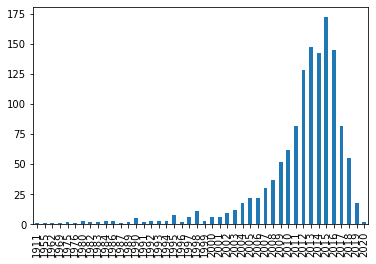

In [81]:
all_refs_uniq.loc[:,'year'] = all_refs_uniq.loc[:, 'year'].astype(int)

year_counts = all_refs_uniq.query('year > 1900 and year < 2022').loc[:,'year'].value_counts().sort_index()
year_counts.plot(kind='bar')
